## Extreme Gradient Boosting
(Comments and codes come from the Nicolas Vandepu's book "Data Science for Supply Chain Forecasting")

Chen and Guestrin (from the University of Washington) proposed a new gradient boosting algorithm—called Extreme Gradient Boosting or XGBoost—and formalized it in 2016.2 The data science community has since widely used this implementation, with excellent results. This is simply one of the most powerful machine learning algorithms currently available.

As users, XGBoost will bring us three improvements compared to AdaBoost and regular Gradient Boosting: 
                
- XGBoost is faster. 
- XGBoost is (generally) better 
- XGBoost allows for more parameters to be optimized.

In [1]:
import pandas as pd

# Define the import_data function
def import_data():
    data = pd.read_csv(file_path)
    data['Period'] = data['Year'].astype(str) + '-' + data['Month'].astype(str).str.zfill(2)
    df = pd.pivot_table(data=data, values=['Quantity'], index='Make', columns='Period', aggfunc='sum', fill_value=0)
    return df

# URL of the CSV file
file_path = "https://supchains.com/wp-content/uploads/2021/07/norway_new_car_sales_by_make1.csv"

# Create the DataFrame using the import_data function
df = import_data()

# Now 'df' contains the data from the provided URL in the desired format.

# Print the DataFrame
print(df.head())

             Quantity                                                          \
Period        2007-01 2007-02 2007-03 2007-04 2007-05 2007-06 2007-07 2007-08   
Make                                                                            
Alfa Romeo         16       9      21      20      17      21      14      12   
Aston Martin        0       0       1       0       4       3       3       0   
Audi              599     498     682     556     630     498     562     590   
BMW               352     335     365     360     431     477     403     348   
Bentley             0       0       0       0       0       1       0       0   

                              ...                                          \
Period       2007-09 2007-10  ... 2016-04 2016-05 2016-06 2016-07 2016-08   
Make                          ...                                           
Alfa Romeo        15      10  ...       3       1       2       1       6   
Aston Martin       0       0  ...       0  

### Training and Test Sets Creation
Now that we have our dataset with the proper formatting, we can create a function datasets() to populate a training and a test set.

In [2]:
import numpy as np

# Define the datasets function with x_len as an argument
def datasets(df, x_len=12, y_len=1, test_loops=12):
    D = df.values
    rows, periods = D.shape
    
    # Training set creation
    loops = periods + 1 - x_len - y_len
    train = []
    for col in range(loops):
        train.append(D[:, col:col + x_len + y_len])
    train = np.vstack(train)
    X_train, Y_train = np.split(train, [-y_len], axis=1)
    
    # Test set creation
    if test_loops > 0:
        X_train, X_test = np.split(X_train, [-rows * test_loops], axis=0)
        Y_train, Y_test = np.split(Y_train, [-rows * test_loops], axis=0)
    else:
        X_test = D[:, -x_len:]
        Y_test = np.full((X_test.shape[0], y_len), np.nan)
    
    # Formatting required for scikit-learn
    if y_len == 1:
        Y_train = Y_train.ravel()
        Y_test = Y_test.ravel()
        
    return X_train, Y_train, X_test, Y_test

### Call our new function datasets(df) as well as import_data()
We can now easily call our new function datasets(df) as well as import_data(). We obtain the datasets we need to feed our machine learning algorithm (X_train and Y_train) and the datasets we need to test it (X_test and Y_test)

In [3]:
# Import data
df = import_data()

# Create training and test sets using the datasets function
X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=1, test_loops=12)

### Analyzing Feature Importance with XGBoost in Machine Learning
Machine learning algorithms often operate on large datasets with numerous features, making it essential to understand the importance of each feature in the model's predictions. XGBoost, an efficient and scalable machine learning algorithm, provides a built-in method to assess feature importance. In this code snippet, we utilize XGBoost to create a regression model and analyze the importance of features using its plotting capabilities. Let's delve into the organized version of the code to gain insights into how feature importance is visualized and interpreted in the context of machine learning.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

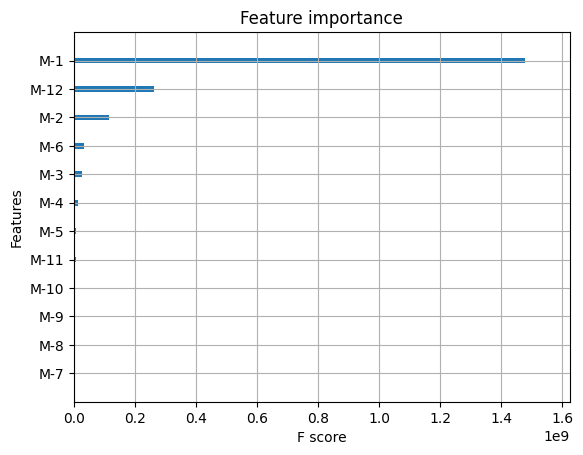

In [4]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

# Initializing XGBoost regression model with specified parameters
XGB = XGBRegressor(n_jobs=-1, max_depth=10, n_estimators=100, learning_rate=0.2)

# Fitting the XGBoost model with training data
XGB.fit(X_train, Y_train)

# Assigning feature names to the booster object for visualization
XGB.get_booster().feature_names = [f'M{x-12}' for x in range(12)]

# Plotting feature importance using XGBoost's plot_importance function
xgb.plot_importance(XGB, importance_type='total_gain', show_values=False)

### Evaluation and Early Stopping
When an XGBoost model is trained on a dataset, you can measure—after each iteration—its accuracy against an evaluation set.

**Evaluation Set**
An evaluation set is a set of data that is left aside from the training set to be used as a monitoring dataset during the training. A validation set (random subset of the training set) or a holdout set (last period of the training set) can be used as an evaluation set.

If you want to optimize your model’s parameters, the best practice is of course to run a cross-validation random search. But rather than trying different models with a different number of trees, you could grow your model indefinitely, and stop it when there is no more improvement on the evaluation set (for some consecutive iterations).

In practice, once the model does not see an accuracy improvement on the evaluation test for a determined number of extra trees, XGBoost will revert to the last iteration that brought extra accuracy to the evaluation set. With this technique, you get rid of the burden of number-of-trees optimization, and you are sure to grow your model up to the right level. 
               This early stopping technique will help us avoid overfitting our model to the training set, and at the same time, reduce training time. One stone, two birds. The early stopping technique is a very useful capability of XGBoost.

In [6]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Splitting the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.15)

# Setting up the XGBoost regressor with specified hyperparameters
# Including the `eval_metric` and `early_stopping_rounds` during initialization
XGB = XGBRegressor(
    n_jobs=-1, 
    max_depth=10, 
    n_estimators=1000, 
    learning_rate=0.01, 
    early_stopping_rounds=100,
    eval_metric='mae'
)

# Fitting the model on the training data
# Note: No need to specify `early_stopping_rounds` and `eval_metric` here
XGB.fit(
    x_train, 
    y_train, 
    verbose=False, 
    eval_set=[(x_val, y_val)]
)

# Printing the best iteration number
print(f'Best iteration: {XGB.best_iteration}')

# Printing the best score
print(f'Best score: {XGB.best_score}')

Best iteration: 996
Best score: 32.34355200170273


#### Using holdout dataset as the evaluation dataset
Instead of a validation set, you can also use a holdout dataset as the evaluation dataset. This can perform better on some datasets.

In [20]:
def datasets_holdout(df, x_len=12, y_len=1, test_loops=12, holdout_loops=0):
    D = df.values
    rows, periods = D.shape
    
    # Training set creation
    train_loops = periods + 1 - x_len - y_len - test_loops
    train = []
    for col in range(train_loops):
        train.append(D[:, col:col + x_len + y_len])
    train = np.vstack(train)
    X_train, Y_train = np.split(train, [-y_len], axis=1)
    
    # Holdout set creation
    if holdout_loops > 0:
        X_train, X_holdout = np.split(X_train, [-rows * holdout_loops], axis=0)
        Y_train, Y_holdout = np.split(Y_train, [-rows * holdout_loops], axis=0)
    else:
        X_holdout, Y_holdout = np.array([]), np.array([])
    
    # Test set creation
    if test_loops > 0:
        X_train, X_test = np.split(X_train, [-rows * test_loops], axis=0)
        Y_train, Y_test = np.split(Y_train, [-rows * test_loops], axis=0)
    else:
        # No test set: X_test is used to generate the future forecast
        X_test = D[:, -x_len:]
        Y_test = np.full((X_test.shape[0], y_len), np.nan)  # Dummy value
    
    # Formatting required for scikit-learn
    if y_len == 1:
        Y_train = Y_train.ravel()
        Y_test = Y_test.ravel()
        Y_holdout = Y_holdout.ravel()
    
    return X_train, Y_train, X_holdout, Y_holdout, X_test, Y_test

In [22]:
# Generating training, holdout, and test sets using a custom function
X_train, Y_train, X_holdout, Y_holdout, X_test, Y_test = datasets_holdout(df, x_len=12, y_len=1, test_loops=12, holdout_loops=12)

# Initializing and training XGBoost regression model
XGB = XGBRegressor(n_jobs=-1, max_depth=10, n_estimators=2000, learning_rate=0.01)
XGB = XGB.fit(X_train, Y_train, verbose=False, eval_metric='mae')

In [23]:
import pandas as pd
from sklearn.metrics import mean_absolute_error

# Predicting values for holdout and test sets
predictions_holdout = XGB.predict(X_holdout)
predictions_test = XGB.predict(X_test)

# Calculating MAE for holdout and test sets
mae_holdout = mean_absolute_error(Y_holdout, predictions_holdout)
mae_test = mean_absolute_error(Y_test, predictions_test)

# Creating a DataFrame with the results
results_data = {
    'Dataset': ['Holdout', 'Test'],
    'Mean Absolute Error (MAE)': [mae_holdout, mae_test]
}

results_df = pd.DataFrame(results_data)

# Displaying the table
print(results_df)

   Dataset  Mean Absolute Error (MAE)
0  Holdout                  39.447520
1     Test                  31.553178


**Important note:** It's important to compare the MAE to some baseline or to the range of the target variable to understand the magnitude of these errors fully. Additionally, if these datasets are different in size, distribution, or feature space, the MAE values may not be directly comparable.

### Hyperparameter Tuning Grid for Gradient Boosting Algorithm

#### Optimization
Now that we have defined the parameter space we want to test, we can continue and perform a cross-validation random search

In [9]:
from sklearn.model_selection import RandomizedSearchCV

# Initialize the XGBRegressor with default parameters
XGB = XGBRegressor()

# Define the hyperparameters to be tuned
params = {
    'max_depth': [5, 6, 7, 8, 10, 11],
    'learning_rate': [0.005, 0.01, 0.025, 0.05, 0.1, 0.15],
    'colsample_bynode': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  # max_features
    'colsample_bylevel': [0.8, 0.9, 1.0],  # max_features per level
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # max_features
    'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],  # max_samples
    'min_child_weight': [5, 10, 15, 20, 25],  # min_samples_leaf
    'reg_alpha': [1, 5, 10, 20, 50],
    'reg_lambda': [0.01, 0.05, 0.1, 0.5, 1.1],    'n_estimators': [1000]
}

# Define RandomizedSearchCV
XGB_cv = RandomizedSearchCV(
    XGB, 
    params, 
    cv=5, 
    n_jobs=-1, 
    verbose=1, 
    n_iter=1000, 
    scoring='neg_mean_absolute_error'
)

# Fit the model
XGB_cv.fit(X_train, Y_train)

# Print the best parameters
print('Tuned XGBoost Parameters: ', XGB_cv.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Tuned XGBoost Parameters:  {'subsample': 0.6, 'reg_lambda': 1.1, 'reg_alpha': 5, 'n_estimators': 1000, 'min_child_weight': 20, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.8, 'colsample_bynode': 0.5, 'colsample_bylevel': 1.0}


**Note:** In this setup, the eval_set parameter is not directly set in the fit_params since it's not straightforward to use with cross-validation (like RandomizedSearchCV), as each fold will have a different validation set.

**Pro-Tip - Double Search**

If you don't feel confident about setting the various parameter ranges to be tested, do not hesitate to run two optimizations one after the other- the first one with wide parameter ranges; then, a second one performed in more detail around the first optimal values found.

We can now train XGBoostRegressor with RandomizedSearchCV-Optimized Parameters

In [13]:
# RandomizedSearchCV object with best parameters determined
best_params = XGB_cv.best_params_

# Initialize XGBRegressor with the best parameters
XGB = XGBRegressor(n_jobs=-1, **best_params)

# Assuming fit_params is defined as before, without early stopping rounds and eval_metric
fit_params = {
    'verbose': False
}

# Fit the model with the training data
XGB.fit(x_train, y_train, **fit_params)

# Print the best iteration and score if available
# These attributes are only available if early stopping is used
if hasattr(XGB.get_booster(), 'best_iteration'):
    print(f'Best iteration: {XGB.get_booster().best_iteration}')
if hasattr(XGB.get_booster(), 'best_score'):
    print(f'Best score: {XGB.get_booster().best_score}')

In [17]:
# Make predictions on the training and test sets
y_train_pred = XGB.predict(X_train)
y_test_pred = XGB.predict(X_test)

In [19]:
# Define the kpi_ML function
def kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name=""):
    df = pd.DataFrame(columns=['MAE', 'RMSE', 'Bias'], index=['Train', 'Test'])
    df.index.name = name

    df.loc['Train', 'MAE'] = 100 * np.mean(np.abs(Y_train - Y_train_pred)) / np.mean(Y_train)
    df.loc['Train', 'RMSE'] = 100 * np.sqrt(np.mean((Y_train - Y_train_pred)**2)) / np.mean(Y_train)
    df.loc['Train', 'Bias'] = 100 * np.mean((Y_train - Y_train_pred)) / np.mean(Y_train)

    df.loc['Test', 'MAE'] = 100 * np.mean(np.abs(Y_test - Y_test_pred)) / np.mean(Y_test)
    df.loc['Test', 'RMSE'] = 100 * np.sqrt(np.mean((Y_test - Y_test_pred)**2)) / np.mean(Y_test)
    df.loc['Test', 'Bias'] = 100 * np.mean((Y_test - Y_test_pred)) / np.mean(Y_test)

    df = df.astype(float).round(1)  # Round numbers for display
    print(df)

# Evaluate the model predictions
kpi_ML(Y_train, y_train_pred, Y_test, y_test_pred, name='XGBoost_optimized')

                    MAE  RMSE  Bias
XGBoost_optimized                  
Train              13.9  33.9  -0.2
Test               17.7  44.6   2.9


### Multiple Periods Evaluation
Just like AdaBoost, XGBoost unfortunately cannot forecast multiple periods at once, so we will also use scikit-learn’s MultiOutputRegressor. To make the model faster, you should set n_jobs=1 in XGBRegressor and n_jobs=-1 for MultiOutputRegressor. (In other words, a thread will be working independently on each of the future forecast periods, rather than multiple threads working on single forecast periods one by one.)

In [24]:
from sklearn.multioutput import MultiOutputRegressor

# Training and testing
X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=6, test_loops=12)
XGB = XGBRegressor(n_jobs=1, max_depth=10, n_estimators=100, learning_rate=0.2)
multi = MultiOutputRegressor(XGB, n_jobs=-1)
multi.fit(X_train, Y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.2, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=1,
                                            num_parallel_tree=None,
                                            random_state=None, ...),
                     n_jobs=-1)

In [26]:
# Future Forecast
X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=6, test_loops=0)
XGB = XGBRegressor(n_jobs=1, max_depth=10, n_estimators=100, learning_rate=0.2)
multi = MultiOutputRegressor(XGB, n_jobs=-1)
multi.fit(X_train, Y_train)

# Creating the forecast DataFrame with predictions and setting the index
forecast = pd.DataFrame(data=multi.predict(X_test), index=df.index)

print(forecast.head())

                        0            1            2            3           4  \
Make                                                                           
Alfa Romeo      10.184089     8.149643     7.404906     9.503287   11.133018   
Aston Martin     0.190329     0.682681     0.191748     0.093967    0.176659   
Audi           733.652588   742.841309   594.797241   659.938660  743.312378   
BMW           1060.885254  1101.544800  1228.265137  1222.016724  929.175598   
Bentley          0.166028     0.284376     0.311742     0.516105    0.599086   

                       5  
Make                      
Alfa Romeo     16.790682  
Aston Martin    0.640640  
Audi          620.856140  
BMW           743.211670  
Bentley         0.230187  
